<a href="https://colab.research.google.com/github/The-Powder-of-Data/detecting_deforestation/blob/main/src/notebooks/MCL_from_GCP_Bucket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FastAI Approach W Connected GCP Bucket

## Functions

In [1]:
def mount_bucket(bucket_name):
  """
  This fn authenticates your google account and mounts to you Google Cloud Platform bucket
  """
  !echo "deb http://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
  !curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
  !sudo apt-get -y -q update
  !sudo apt-get -y -q install gcsfuse

  from google.colab import auth
  auth.authenticate_user()
  !mkdir -p gcp_bucket 
  !gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 {bucket_name} gcp_bucket


In [ ]:
def fastai_config():
  """
  This function sets the data path and config location to be in the content folder for Google Colab
  """
  
  Config.DEFAULT_CONFIG = {
          'data_path': '/content/fastai/data',
          'model_path': '/content/fastai/models'
      }

  Config.create('/content/fastai/cofig/myconfig.yml')
  Config.DEFAULT_CONFIG_PATH = '/content/fastai/cofig/myconfig.yml'


In [ ]:
def bucket_data_transfer():
  """
  Unzips the jpeg dataset labels csv from our GCP bucket to the correct instance directory as staging for modeling.
  """
  # unzip from CGP bucket to instance
  !unzip /content/gcp_bucket/zip_files/train-jpg.zip -d {path}

  # copy csv of labels to path location 
  ! cp /content/gcp_bucket/images/data/train_classes.csv -d {path}

## Installs

In [27]:
!pip install fastbook

     |████████████████████████████████| 719 kB 4.1 MB/s 
     |████████████████████████████████| 197 kB 65.8 MB/s 
     |████████████████████████████████| 1.2 MB 48.3 MB/s 
     |████████████████████████████████| 60 kB 8.0 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


## Imports

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
import pandas as pd
import numpy as np

from google.colab import auth #to connect to GCP Bucket



## Connect to Bucket



In [3]:
mount_bucket('jhl_deforestation_project')

deb http://packages.cloud.google.com/apt gcsfuse-bionic main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  68567      0 --:--:-- --:--:-- --:--:-- 68567
OK
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [85.2 kB]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [748 kB]
Get:7 http://packages.cloud.google.com/apt gcsfuse-bionic InRelease [5,391 B]
Get:8 http://security.ubuntu.com/ubuntu bi

## fastai 

### Set config parameters

In [5]:
# setup the configf file for fastai to access the image data in cpg
Config.DEFAULT_CONFIG = {
        'data_path': '/content/fastai/data',
        'model_path': '/content/fastai/models'
    }

Config.create('/content/fastai/cofig/myconfig.yml')
Config.DEFAULT_CONFIG_PATH = '/content/fastai/cofig/myconfig.yml'

In [6]:
# setting path variable for ease of use
path = Config.data_path()
path

PosixPath('/content/fastai/data')

In [7]:
# unzip from CGP bucket to instance
!unzip /content/gcp_bucket/zip_files/train-jpg.zip -d {path}

# copy csv of labels to path location 
! cp /content/gcp_bucket/images/data/train_classes.csv -d {path}

Streaming output truncated to the last 5000 lines.
  inflating: /content/fastai/data/train-jpg/train_6919.jpg  
  inflating: /content/fastai/data/__MACOSX/train-jpg/._train_6919.jpg  
  inflating: /content/fastai/data/train-jpg/train_14115.jpg  
  inflating: /content/fastai/data/__MACOSX/train-jpg/._train_14115.jpg  
  inflating: /content/fastai/data/train-jpg/train_14673.jpg  
  inflating: /content/fastai/data/__MACOSX/train-jpg/._train_14673.jpg  
  inflating: /content/fastai/data/train-jpg/train_1910.jpg  
  inflating: /content/fastai/data/__MACOSX/train-jpg/._train_1910.jpg  
  inflating: /content/fastai/data/train-jpg/train_35865.jpg  
  inflating: /content/fastai/data/__MACOSX/train-jpg/._train_35865.jpg  
  inflating: /content/fastai/data/train-jpg/train_12202.jpg  
  inflating: /content/fastai/data/__MACOSX/train-jpg/._train_12202.jpg  
  inflating: /content/fastai/data/train-jpg/train_24968.jpg  
  inflating: /content/fastai/data/__MACOSX/train-jpg/._train_24968.jpg  
  inflat

### Data Processing

In [8]:
# get the train labels csv from gdrive
df = pd.read_csv(path/'train_classes.csv')
print(df.shape)
df.head()

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


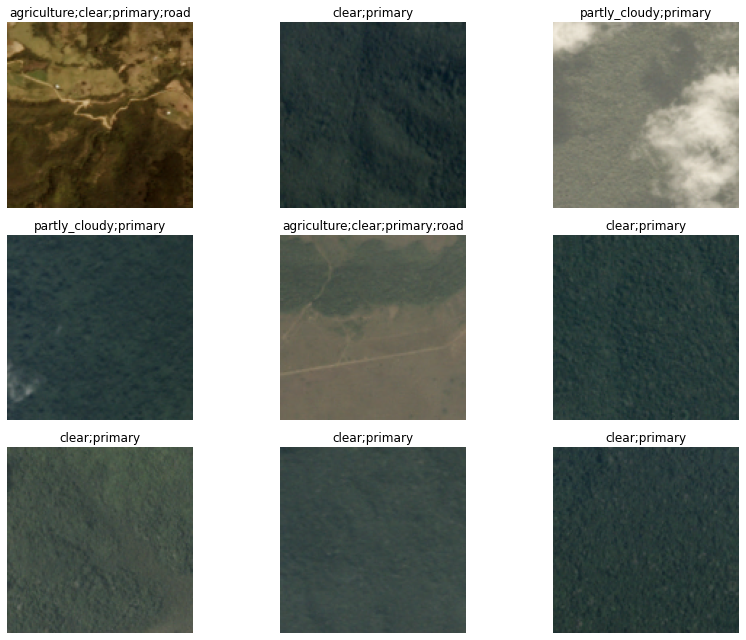

In [9]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
# we put flip_vert=True because that makes contextual sense fore satellite images
# do not need max_warp as satelight images alwasy have same perspective looking down on the earth

# data block pipeline we use parenthesis around
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_classes.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

data = (src.transform(tfms, size=128) #observe that image size is 256 but we started smaller for speed
        .databunch().normalize(imagenet_stats))

data.show_batch(rows=3, figsize=(12,9))

### Modeling - Resnet

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


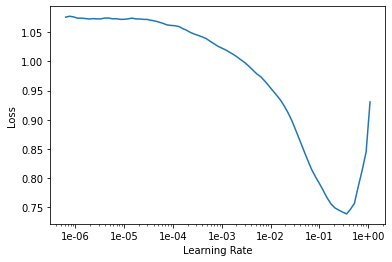

In [10]:
# model time
arch = models.resnet50

# using accuracy threshold becasue comparing proba to a threshold to generate accuracy 
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2) # we also set the threshold to 0.2 to have more items appear

# defining the learner as CNN
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

# use lr find to find a good learning rate
learn.lr_find()
learn.recorder.plot()


In [11]:
lr = 0.01
learn.fit_one_cycle(5, slice(lr))
# we can see that the results are pretty good for the kaggle competition of f1 evaluation

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.138699,0.117236,0.945260,0.899157,02:15
1,0.112814,0.098911,0.950790,0.914126,02:23
2,0.101493,0.091860,0.956429,0.920424,02:34
3,0.095275,0.088491,0.956298,0.922945,02:17
4,0.091006,0.087111,0.956858,0.925475,02:14


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


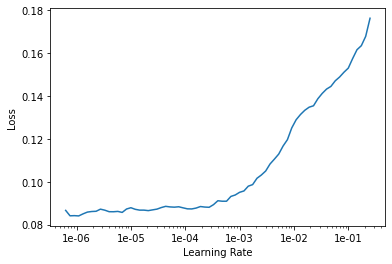

In [12]:
learn.save('stage-1-rn50')

learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

In [14]:
# example of discrimanative learning rates
# the first half is lowest point - 10, second is the fixed learning rate /5
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.098854,0.089688,0.954300,0.922561,02:18
1,0.098312,0.088995,0.954307,0.925529,02:18
2,0.089976,0.087001,0.957570,0.925783,02:18
3,0.085206,0.083971,0.959510,0.928873,02:34
4,0.079176,0.083019,0.959322,0.928612,02:44


In [15]:
learn.save('stage-2-rn50')

**New input size Trick**: <br>
Use same learner but a new data bunch with full size 256 images.

This means that even though we were close to over fitting we essentially can start on a whole new dataset (256 pixels) but still with the abstracted training of the first cnn learner

In [16]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
print(data.train_ds[0][0].shape)

torch.Size([3, 256, 256])


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


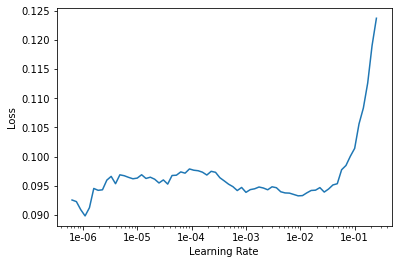

In [17]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [18]:
# rule of thumb maybe 10x smaller than where it peaks
lr = 1e-2/2

# lets fit a bit more
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.086240,0.085029,0.956327,0.926226,03:56
1,0.089880,0.085343,0.959525,0.926602,03:56
2,0.083051,0.083803,0.959474,0.927823,03:57
3,0.082112,0.081906,0.958442,0.928809,04:00
4,0.080326,0.081647,0.959452,0.931026,03:57


In [19]:
learn.save('stage-1-256-rn50')
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.084555,0.084870,0.956836,0.926017,04:10
1,0.087445,0.084041,0.955826,0.928681,04:13
2,0.083018,0.082348,0.957258,0.929383,04:12
3,0.079605,0.080987,0.959517,0.931617,04:12
4,0.076723,0.080731,0.959641,0.931037,04:12


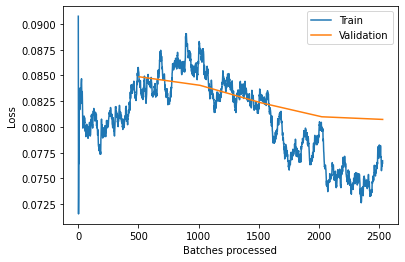

In [20]:
learn.recorder.plot_losses()

In [21]:
learn.save('stage-2-256-rn50')
learn.export('stage2_256_rn50.pkl')

In [24]:
# Do we want to copy this model output to our GCP Bucket
! cp /content/fastai/data/stage2_256_rn50.pkl /content/gcp_bucket/models/

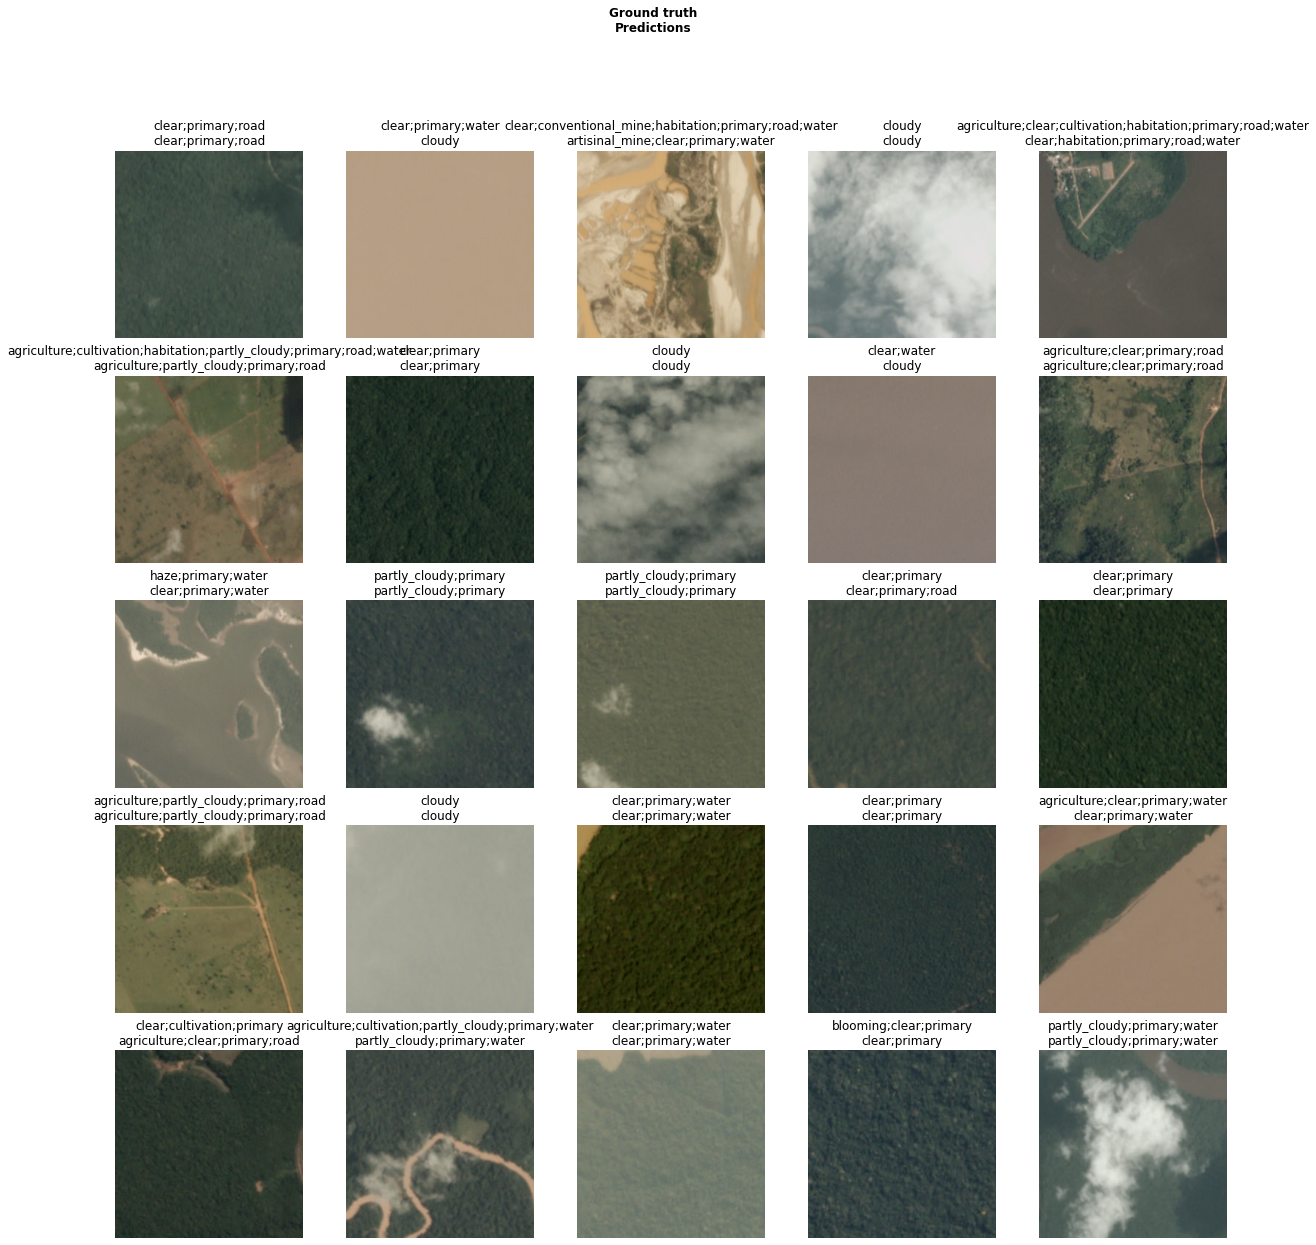

In [22]:
# show results & labels
learn.show_results(frows=3, igsize=(15,15))

In [ ]:
# If we want to see all 50 layers of resnet architecture
#learn.summary()

## Load Model and Predict
come back to this and figure out how to load and predict for a test set
https://colab.research.google.com/github/karthikraja95/fsdl_deforestation_detection/blob/master/fsdl_deforestation_detection/experimental/FSDL_Final_Model.ipynb#scrollTo=Jkb6LxYVkDQf

In [28]:
#load
#inference = learn.load('/content/gcp_bucket/models/stage2_256_rn50.pkl')
from fastbook import load_learner

inference = load_learner('/content/gcp_bucket/models/stage2_256_rn50.pkl')

[autoreload of fastai.basics failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
NameError: name 'noops' is not defined
]
[autoreload of fastai.torch_core failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
NameError: name '_old_torch_cuda_set_device' is not defined
]
[autoreload of fastai.layers failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
AttributeError: module 'fastai.torch_core' has no attribute 'show_image'
]
[autoreload of fastai.metrics failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247,

ModuleNotFoundError: ignored

In [ ]:
additional_test_path = Path('test-jpg-additional/test-jpg-additional')
test_path = Path('planet/planet/test-jpg')
submission_df = pd.read_csv(path/'sample_submission.csv')
testing_path = (submission_df['image_name'] + '.jpg').apply(lambda x: test_path/x if x.startswith('test') else additional_test_path/x)

def prediction(filename='submission.csv', tta=False):
    tst_dl = learn.dls.test_dl(testing_path)
    if tta:
        predictions = learn.tta(dl = tst_dl)
    else:
        predictions = learn.get_preds(dl = tst_dl)
    predlist = [' '.join(learn.dls.vocab[i]) for i in (predictions[0] > 0.2)]

    df = submission_df
    df['tags'] = predlist

    df.to_csv(filename, index=False)
    return df

In [ ]:
prediction('submission_tta.csv', tta=True)